# Importing Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,re,h5py
import time
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten,Conv2D,MaxPooling2D, Dropout,BatchNormalization,ZeroPadding2D,Concatenate,Input
from keras.models import Model
from keras.callbacks import CSVLogger, ReduceLROnPlateau
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [2]:


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define Paths

In [3]:
PATH = "/content/drive/MyDrive/minor_gans/new_chest_xray"
METRICS_PATH="/content/drive/MyDrive/minor_gans/output/densenet/"
MODEL_NAME="DenseNEt201gans"
print("PWD", PATH)

PWD /content/drive/MyDrive/minor_gans/new_chest_xray


# Define Metrics

In [4]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [5]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from drive

In [7]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [8]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['NORMAL', 'PNEUMONIA']


In [9]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        img_data_list.append(x)


Loaded the images of dataset-NORMAL

Loaded the images of dataset-PNEUMONIA



In [10]:
img_data = np.array(img_data_list)
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(7856, 1, 32, 32, 3)
(1, 7856, 32, 32, 3)
(7856, 32, 32, 3)


# Train and Test Data

In [11]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:1584] = 0
labels[1584:] = 1
names = ['NORMAL', 'PNEUMONIA']

sample 7856


In [12]:
from sklearn.utils import shuffle


In [13]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [14]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Add a new classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
model.summary()


74836368/74836368 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,814,274
Trainable params: 492,290
Non-tr

In [15]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
print(METRICS_PATH+MODEL_NAME+'.csv')

/content/drive/MyDrive/minor_gans/output/densenet/DenseNEt201gans.csv


# Model Training

### With Augumentation

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:
def results():
  print('------------Training time is seconds:%s',time.time()-start_time)
  scores = model.evaluate(x_test, y_test, verbose=1)

  #history keys and values
  print(history.history.keys())
  print(history.history.values())

  #Metrics for testing
  print(scores)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  print('Test f1:',scores[2])
  print('Test sensitivity:',scores[3])
  print('Test specificity:',scores[4])
  print("Max Test accuracy", max(history.history['val_accuracy']))

  import matplotlib.pyplot as plt
  # summarize history for accuracy

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
  plt.show()

  # summarize history for loss

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
  plt.show()


In [ ]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Using real-time data augmentation.


<ipython-input-21-eb7f1dcb9614>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/100
293/293 [==============================] - 39s 66ms/step - loss: 0.4812 - accuracy: 0.7658 - f1: 0.7659 - specificity: 0.7659 - sensitivity: 0.7659 - val_loss: 0.3820 - val_accuracy: 0.8498 - val_f1: 0.8498 - val_specificity: 0.8498 - val_sensitivity: 0.8498 - lr: 6.0000e-05
Epoch 2/100
293/293 [==============================] - 10s 35ms/step - loss: 0.3724 - accuracy: 0.8344 - f1: 0.8344 - specificity: 0.8344 - sensitivity: 0.8344 - val_loss: 0.3137 - val_accuracy: 0.8848 - val_f1: 0.8845 - val_specificity: 0.8845 - val_sensitivity: 0.8845 - lr: 6.0000e-05
Epoch 3/100
293/293 [==============================] - 24s 81ms/step - loss: 0.3384 - accuracy: 0.8529 - f1: 0.8530 - specificity: 0.8530 - sensitivity: 0.8530 - val_loss: 0.2978 - val_accuracy: 0.8942 - val_f1: 0.8948 - val_specificity: 0.8948 - val_sensitivity: 0.8948 - lr: 6.0000e-05
Epoch 4/100
293/293 [==============================] - 11s 36ms/step - loss: 0.3143 - accuracy: 0.8664 - f1: 0.8664 - specificity: 0.866

In [ ]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 1110.4844617843628
37/37 [==============================] - 1s 22ms/step - loss: 0.2558 - accuracy: 0.9036 - f1: 0.9035 - specificity: 0.9035 - sensitivity: 0.9035
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.48117756843566895, 0.3723655641078949, 0.3383566737174988, 0.3142651319503784, 0.29395562410354614, 0.299602210521698, 0.27925291657447815, 0.2792121171951294, 0.27300825715065, 0.2710118591785431, 0.270293653011322, 0.2690896987915039, 0.2586967349052429, 0.2586420774459839, 0.25773972272872925, 0.239242285490036, 0.25647279620170593, 0.240524560213089, 0.24014151096343994, 0.24542094767093658, 0.24901996552944183, 0.23921020328998566, 0.23050682246685028, 0.2389393299818039, 0.23161761462688446, 0.22603106498718262, 0.23285557329654694, 0.23223164677619934, 0.23677010834217072, 0.24134911596775055, 0.2396022379398346, 0.

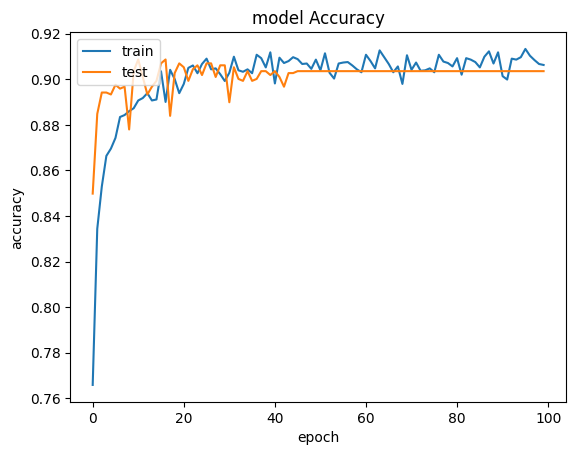

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

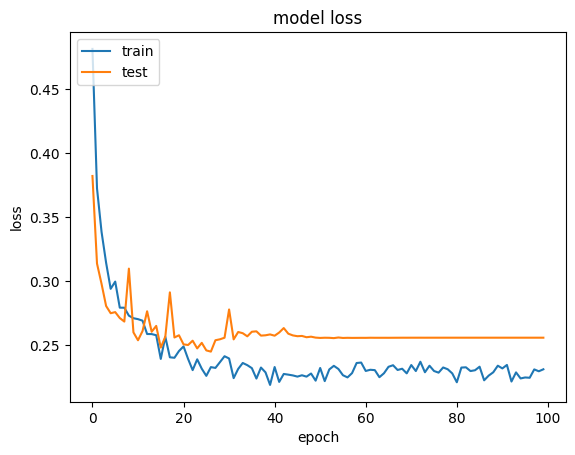

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()

#### Results with aug

### Without Augumentation

In [17]:
MODEL_NAME="Densenet201_waug_gans"

In [18]:
input_shape = (32, 32, 3)
base_model = tf.keras.applications.DenseNet201(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

# Add a new classification head on top of the base model
model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               491776    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 18,814,274
Trainable params: 492,290
Non-trainable params: 18,321,984
____________________________________

In [19]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=6, min_lr=0.5e-10)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+'.csv', append=True, separator=';')
adam = Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.0e-6,amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy',f1,specificity,sensitivity])


In [20]:
batch_size = 16
data_augmentation = False
epochs = 100

In [21]:
import time
start_time = time.time()

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True, callbacks=[lr_reducer,csv_logger])
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                               batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_test, y_test), callbacks=[lr_reducer, csv_logger])

Not using data augmentation.
Epoch 1/100
393/393 [==============================] - 37s 43ms/step - loss: 0.3945 - accuracy: 0.8248 - f1: 0.8249 - specificity: 0.8249 - sensitivity: 0.8249 - val_loss: 0.2770 - val_accuracy: 0.8772 - val_f1: 0.8782 - val_specificity: 0.8782 - val_sensitivity: 0.8782 - lr: 6.0000e-05
Epoch 2/100
393/393 [==============================] - 11s 27ms/step - loss: 0.2627 - accuracy: 0.8945 - f1: 0.8945 - specificity: 0.8945 - sensitivity: 0.8945 - val_loss: 0.2272 - val_accuracy: 0.9103 - val_f1: 0.9110 - val_specificity: 0.9110 - val_sensitivity: 0.9110 - lr: 6.0000e-05
Epoch 3/100
393/393 [==============================] - 10s 25ms/step - loss: 0.2263 - accuracy: 0.9117 - f1: 0.9117 - specificity: 0.9117 - sensitivity: 0.9117 - val_loss: 0.2155 - val_accuracy: 0.9186 - val_f1: 0.9192 - val_specificity: 0.9192 - val_sensitivity: 0.9192 - lr: 6.0000e-05
Epoch 4/100
393/393 [==============================] - 12s 31ms/step - loss: 0.2044 - accuracy: 0.9182 - f1

In [22]:
print('------------Training time is seconds:%s',time.time()-start_time)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 1286.7731766700745
50/50 [==============================] - 3s 20ms/step - loss: 0.1410 - accuracy: 0.9370 - f1: 0.9381 - specificity: 0.9381 - sensitivity: 0.9381
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.3944580554962158, 0.2626952528953552, 0.22625009715557098, 0.20435106754302979, 0.1917508840560913, 0.17905426025390625, 0.17094635963439941, 0.16620303690433502, 0.1550176590681076, 0.15167836844921112, 0.14636024832725525, 0.14213897287845612, 0.1374059021472931, 0.1347896009683609, 0.12735940515995026, 0.125915065407753, 0.12097727507352829, 0.11709191650152206, 0.11682029813528061, 0.10963167995214462, 0.10865002125501633, 0.1060284748673439, 0.10149918496608734, 0.10212396830320358, 0.0950758084654808, 0.09267277270555496, 0.09149786084890366, 0.08680225163698196, 0.08195101469755173, 0.08163663744926453, 0.0804853662

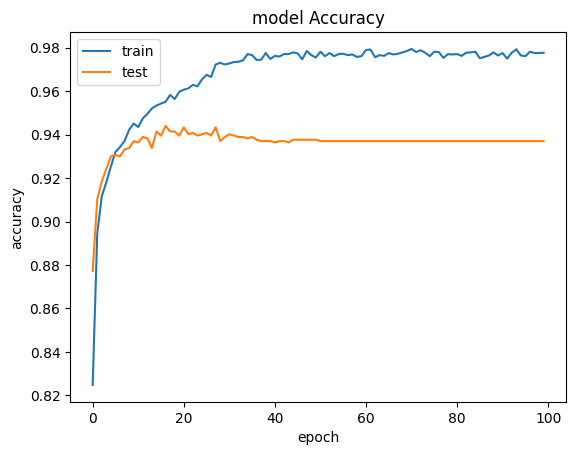

In [23]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()

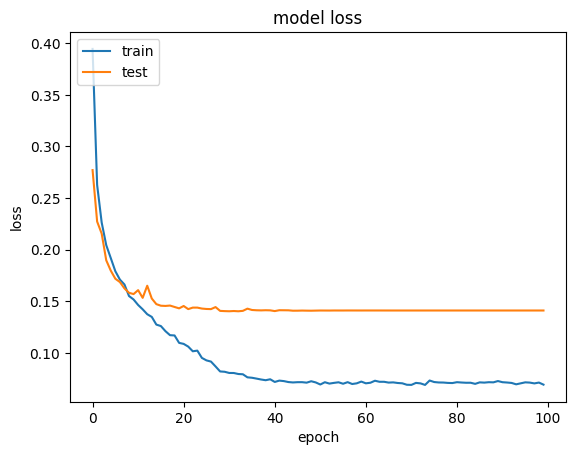

In [24]:

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()